## Vanilla RNNs

We will use Vanilla Recurrent Neural Networks to perform sentiment analysis in `tensorflow.keras` using imdb movie reviews dataset.
The dataset is a subset consisting of 10,000 reviews in the training and test set each. [see here for more info](https://www.tensorflow.org/datasets/catalog/imdb_reviews)

In [1]:
# Import required libraries
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense,GRU
import pickle
import numpy as np
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from pprint import pprint
import json

In [2]:
# We fix a vocabulary size of 5000
# Use the code below to call a small subset of the imdb dataset
# We keep the vocabulary size fixed because it was used to curate the sub-dataset
vocabulary_size = 5000
with open('imdb_mini.pkl','rb') as f:
    X_train, y_train, X_test, y_test = pickle.load(f)


#### Inspect a sample review and its label

In [3]:
# Run the code below to see the first tokenized review and the label
print('---review---')
print(X_train[0])
print('---label---')
print(y_train[0])

---review---
[1, 48, 2498, 2, 16, 4, 4, 1554, 149, 14, 22, 95, 198, 51, 29, 62, 2039, 46, 11, 189, 10, 10, 146, 806, 1588, 21, 2, 195, 75, 69, 79, 3514, 4, 1122, 292, 2, 5, 150, 14, 803, 4, 4351, 57, 45, 24, 618, 6, 2, 15, 289, 7, 4, 2, 323, 2, 2, 5, 4, 85, 381, 160, 87, 698, 284, 4, 293, 1141, 2, 11, 148, 2, 9, 4, 2, 7, 4, 108, 36, 1173, 93, 8, 4171, 363, 36, 71, 2812, 631, 108, 19, 6, 955, 1382, 841, 15, 43, 566, 30, 2, 11, 4, 2997, 4, 681, 9, 1215, 5, 51, 128, 96, 8, 2330, 6, 1215, 22, 74, 8, 2, 12, 19, 6, 1034, 42, 60, 6, 755, 10, 10, 2, 2, 69, 6, 1211, 2790, 159, 12, 60, 569, 4, 1320, 2, 2, 9, 60, 53, 2, 15, 85, 301, 1215, 108, 12, 2, 512, 1089, 3167, 6, 1242, 156, 4, 228, 603, 270, 1328, 15, 2, 2786, 5, 32, 4, 537, 3392, 4, 22, 10, 10, 38, 133, 266, 6, 1034, 92, 3250, 57, 2, 71, 2, 11, 4, 231, 7, 14, 1034, 49, 678, 1409, 7, 4, 65, 887, 8, 30, 2, 18, 4, 682, 2997, 2, 2, 2, 21, 198, 43, 44, 4, 226, 863, 38, 75, 202, 4, 1002, 6, 2, 405, 2, 501, 601, 19, 1465, 228, 2183, 18, 4, 706, 

In [4]:
# You can get the word2id mapping by
# using the imdb.get_word_index() function

#word2id = imdb.get_word_index()
with open('imdb_word_index.json', 'r') as f:
  word2id = json.load(f)
# We need to adjust the mapping by 3 because of tensorflow.keras preprocessing
# more here: https://stackoverflow.com/questions/42821330/restore-original-text-from-keras-s-imdb-dataset
word2id = {k:(v+3) for k,v in word2id.items()}
word2id["<PAD>"] = 0
word2id["<START>"] = 1
word2id["<UNK>"] = 2
word2id["<UNUSED>"] = 3

# Reversing the key,value pair will give the id2word
id2word = {i: word for word, i in word2id.items()}
pprint('---review with words---')
pprint(" ".join([id2word[i] for i in X_train[0]]))
pprint('---label---')
pprint(y_train[0]);

'---review with words---'
("<START> if edward <UNK> was the the flicks watching this film then that's "
 "what he would scream out in horror br br i'm sorry folks but <UNK> enough we "
 "had get carter the italian job <UNK> and now this what's the similarities no "
 "it's not exactly a <UNK> that three of the <UNK> star <UNK> <UNK> and the "
 'other stars another great british actor the main common <UNK> in those <UNK> '
 "is the <UNK> of the films they weren't made to impress hollywood they were "
 'quirky english films with a unique charm atmosphere that just cannot be '
 '<UNK> in the usa the word is cult and what better way to destroy a cult film '
 'than to <UNK> it with a remake or even a sequel br br <UNK> <UNK> had a '
 'tough task before it even hit the road <UNK> <UNK> is even more <UNK> that '
 'other said cult films it <UNK> genre intelligent scripts a grade actors the '
 'music score set pieces that <UNK> description and all the stories '
 "surrounding the film br br so he

Maximum review length and minimum review length

### ⏸ The `<UNK>` tag is reserved for?


#### A. Special characters
#### B. Out of vocabulary words
#### C. Start of sentence
#### D. End of sentence

In [5]:
### edTest(test_chow1) ###
# Submit an answer choice as a string below (eg. if you choose option C, put 'C')
answer1 = '___'

In [6]:
# For training we need our sequences to be of fixed length, but the reviews
# are of different sizes
print(f'Maximum review length: {len(max([i for i in X_train]+[i for i in X_test], key=len))}')
print(f'Minimum review length: {len(min([i for i in X_train]+[i for i in X_test], key=len))}')

Maximum review length: 2494
Minimum review length: 7


In [7]:
# We also create two indices for short and long reviews
# we will use this later
idx_short = [i for i,val in enumerate(X_train) if len(val)<100]
idx_long = [i for i,val in enumerate(X_train) if len(val)>500]

### Pad sequences

In order to feed this data into our RNN, all input documents must have the same length. We will limit the maximum review length to max_words by truncating longer reviews and padding shorter reviews. We can accomplish this using the pad_sequences() function in `tensorflow.keras`. For now, set max_words to 500.

### ⏸ If we use *post-padding* on a sequence, the new sequence is"


#### A. "Padded with zeros before the start of original sequence"
#### B. "Padded with zeros after the end of the original sequence"
#### C. "Padded with ones before the start of original sequence"
#### D. "Padded with ones after the end of the original sequence"

In [8]:
### edTest(test_chow2) ###
# Submit an answer choice as a string below (eg. if you choose option C, put 'C')
answer2 = '___'

In [9]:
# We will clip large reviews and pad smaller reviews to 500 words
max_words = 500
# We can pad the smaller sequences with 0s before, or after.
# This choice can severely affect network performance
# In the first case we, will pad after the sequence
postpad_X_train = sequence.pad_sequences(X_train, maxlen=max_words,padding='post')
postpad_X_test = sequence.pad_sequences(X_test, maxlen=max_words,padding='post')

### RNN model for sentiment analysis

We build the model architecture in the code cell below. We have imported some layers from `tensorflow.keras` that you might need but feel free to use any other layers / transformations you like.

Remember that our input is a sequence of words (technically, integer word IDs) of maximum length = max_words, and our output is a binary sentiment label (0 or 1).

In [10]:
def model_maker(summary=True,gru=False):
# One layer RNN model with 32 rnn cells
    embedding_size=32
    model=Sequential()
    model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))
    
    # We can specify if we want the GRU cell or the vanilla RNN cell
    if gru:
        model.add(GRU(embedding_size))
    else:
        model.add(SimpleRNN(embedding_size))
    model.add(Dense(1, activation='sigmoid'))
    if summary:
        print(model.summary())
        
    # model compile step
    model.compile(loss='binary_crossentropy', 
                 optimizer='adam', 
                 metrics=['accuracy'])    
    return model

## Trace Plot analysis
We expect the postpadded model to perform train slowly because of vanishing gradients.
Let us investigate the cause by training two models,
- One with shorter reviews (that were post padded) using `idx_short`
- The other with longer reviews (that were truncated) using `idx_long`

In [11]:
# We build two new models with vanilla RNNs
model_short = model_maker(summary=False)
model_long = model_maker(summary=False)

2022-03-05 08:18:06.212902: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-05 08:18:06.213301: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [12]:
# First we train `model_short` with short reviews

X_short = postpad_X_train[idx_short]
y_short = y_train[idx_short]
epochs = 10
history_short = model_short.fit(X_short, y_short, epochs=epochs,batch_size=640,verbose=0);

In [13]:
# Then we train `model_long` with short reviews

X_long = postpad_X_train[idx_long]
y_long = y_train[idx_long]
history_long = model_long.fit(X_long, y_long, epochs=epochs,batch_size=640,verbose=0);

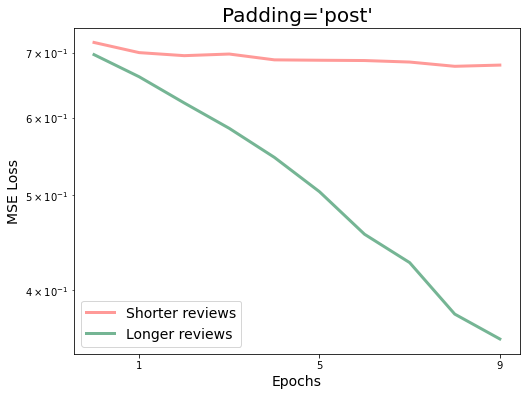

In [14]:
# Helper function to plot the data
# Plot the MSE of the model
plt.rcParams["figure.figsize"] = (8,6)
plt.title("Padding='post'",fontsize=20)
plt.semilogy(history_short.history['loss'], label='Shorter reviews', color='#FF9A98', linewidth=3)
plt.semilogy(history_long.history['loss'],  label='Longer reviews', color='#75B594', linewidth=3)
plt.legend()

# Set the axes labels
plt.xlabel('Epochs',fontsize=14)
plt.xticks(range(1,epochs,4))
plt.ylabel('MSE Loss',fontsize=14)
plt.legend(fontsize=14)
plt.show()

## Pre-padding sequences

As we can see, the vanishing gradient problem is real and can severely affect the training of our network. The short review network negligibly trains, whereas the longer review model trains very well.
To counter this, we will now *pre-pad* the shorter sequences.

In [15]:
# We can pre-pad by using `sequence.pad_sequences` with `padding='pre'`
max_words = 500
prepad_X_train = sequence.pad_sequences(X_train, maxlen=max_words,padding='pre')
prepad_X_test = sequence.pad_sequences(X_test, maxlen=max_words,padding='pre')

### Trace Plot - Take 2

Again, we investigate the trace plots for the two categories, but this time, with pre-padding

In [16]:
# Reinitializing the models for the two categories
model_short = model_maker(summary=False)
model_long = model_maker(summary=False)

In [17]:
# Again we train `model_short` with short reviews

X_short = prepad_X_train[idx_short]
y_short = y_train[idx_short]
epochs = 10
history_short = model_short.fit(X_short, y_short, epochs=epochs,batch_size=640,verbose=0);

In [18]:
# Then we train `model_long` with long reviews

X_long = prepad_X_train[idx_long]
y_long = y_train[idx_long]
history_long = model_long.fit(X_long, y_long, epochs=epochs,batch_size=640,verbose=0);

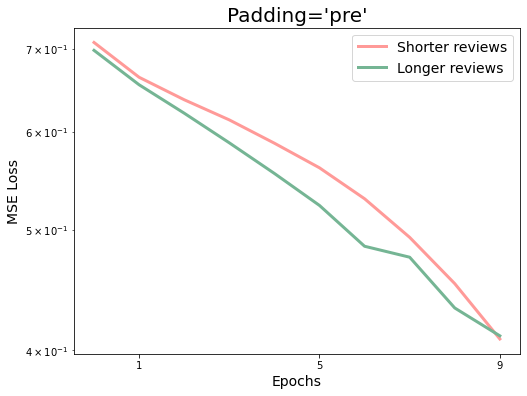

In [19]:
# Helper function to plot the data
# Plot the MSE of the model
plt.rcParams["figure.figsize"] = (8,6)
plt.title("Padding='pre'",fontsize=20)
plt.semilogy(history_short.history['loss'], label='Shorter reviews', color='#FF9A98', linewidth=3)
plt.semilogy(history_long.history['loss'],  label='Longer reviews', color='#75B594', linewidth=3)
plt.legend()

# Set the axes labels
plt.xlabel('Epochs',fontsize=14)
plt.xticks(range(1,epochs,4))
plt.ylabel('MSE Loss',fontsize=14)
plt.legend(fontsize=14)
plt.show()

### 🍲 Further improvements

We solved the vanishing gradient problem by *pre-padding* the sequences, but what other design choices can help you improve performance?

In [20]:
### edTest(test_chow3) ###
# Submit your answer as a string below
answer3 = '___'